In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc
import seaborn as sns
%matplotlib inline

In [9]:
!ls -lhrt ../results/alignments

total 69352
-rw-r--r--  1 jmorton  1396   414K Apr 22 16:39 elmo_alignment_scores.txt
-rw-r--r--  1 jmorton  1396   415K Apr 22 16:39 roberta_alignment_scores.txt
-rw-r--r--@ 1 jmorton  1396    33M Apr 22 16:41 swissprot-pfam-domains.csv
-rw-r--r--@ 1 jmorton  1396   311K Apr 22 16:42 blast_alignment_scores.txt


In [10]:
!ls ../results/alignments/blast

ls: ../results/alignments/blast: No such file or directory


In [11]:
results_dir = '../results/alignments'
attn_fname = f'{results_dir}/roberta_alignment_scores.txt'
elmo_fname = f'{results_dir}/elmo_alignment_scores.txt'
blast_fname = f'{results_dir}/blast_alignment_scores.txt'

attn_df = pd.read_table(attn_fname, header=None)
elmo_df = pd.read_table(elmo_fname, header=None)
blast_df = pd.read_table(blast_fname, header=None)
domains = pd.read_csv(f'{results_dir}/swissprot-pfam-domains.csv', skiprows=1, header=None)
domains.columns = ['protein', 'domain', 'source', 'domain_id', 'start', 'end']

# Only consider a subset of sequences

In [12]:
print(blast_df.shape, attn_df.shape, elmo_df.shape)

(15821, 4) (17647, 5) (17707, 5)


In [13]:
blast_df = blast_df.set_index([0, 1])
attn_df = attn_df.set_index([0, 1])
elmo_df = elmo_df.set_index([0, 1])

In [14]:
idx = list(set(attn_df.index) & set(elmo_df.index) & set(blast_df.index))

In [43]:
blast_df = blast_df.loc[idx]
elmo_df = elmo_df.loc[idx]
attn_df = attn_df.loc[idx]

blast_df = blast_df.loc[~blast_df.index.duplicated(keep='first')]
attn_df = attn_df.loc[~attn_df.index.duplicated(keep='first')]
elmo_df = elmo_df.loc[~elmo_df.index.duplicated(keep='first')]

In [44]:
print(blast_df.shape, attn_df.shape, elmo_df.shape)

(7481, 7) (7481, 7) (7481, 7)


In [45]:
#blast_df[4] = attn_df[4]

In [46]:
attn_df['TPR'] = attn_df[2] / attn_df[4]
attn_df['FPR'] = attn_df[3] / attn_df[4]

elmo_df['TPR'] = elmo_df[2] / elmo_df[4]
elmo_df['FPR'] = elmo_df[3] / elmo_df[4]

blast_df['TPR'] = blast_df[2] / blast_df[4]
blast_df['FPR'] = blast_df[3] / blast_df[4]

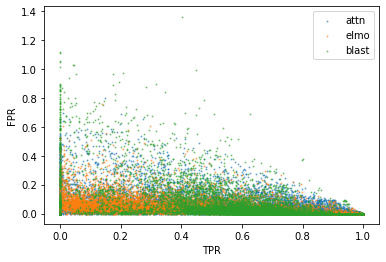

In [47]:
plt.scatter(attn_df['TPR'], attn_df['FPR'], label='attn', s=1, alpha=0.5)
plt.scatter(elmo_df['TPR'], elmo_df['FPR'], label='elmo', s=1, alpha=0.5)
plt.scatter(blast_df['TPR'], blast_df['FPR'], label='blast', s=1, alpha=0.5)

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.legend()

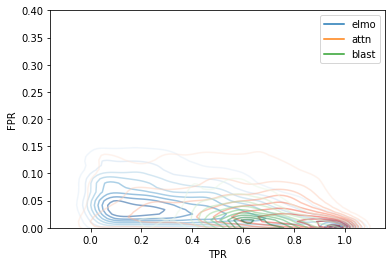

In [48]:
sns.kdeplot(elmo_df['TPR'], elmo_df['FPR'], cmap="Blues", label='elmo', alpha=0.5)
sns.kdeplot(attn_df['TPR'], attn_df['FPR'], cmap="Reds", label='attn', alpha=0.5)
sns.kdeplot(blast_df['TPR'], blast_df['FPR'], cmap="Greens", label='blast', alpha=0.5)

plt.ylim([0, 0.4])
plt.legend()

In [49]:
elmo_df['PPV'] = elmo_df['TPR'] / (elmo_df['TPR'] + elmo_df['FPR'])
attn_df['PPV'] = attn_df['TPR'] / (attn_df['TPR'] + attn_df['FPR'])
blast_df['PPV'] = blast_df['TPR'] / (blast_df['TPR'] + blast_df['FPR'])

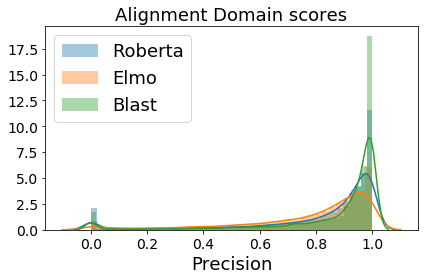

In [50]:
sns.distplot(attn_df['PPV'].dropna(), label='Roberta')
sns.distplot(elmo_df['PPV'].dropna(), label='Elmo')
sns.distplot(blast_df['PPV'].dropna(), label='Blast')
plt.xlabel('Precision', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Alignment Domain scores', fontsize=18)
plt.tight_layout()
#plt.savefig('../figures/alignment_precision.pdf')

In [24]:
from scipy.stats import sem
print(np.mean(attn_df['PPV'].dropna()), sem(attn_df['PPV'].dropna()))
print(np.mean(elmo_df['PPV'].dropna()), sem(elmo_df['PPV'].dropna()))
print(np.mean(blast_df['PPV'].dropna()), sem(blast_df['PPV'].dropna()))

0.8128535210817521 0.0030004173139114546
0.7790934526096392 0.002793767050051311
0.859541233973905 0.0027490212608682315


In [25]:
col='TPR'
print(np.mean(attn_df[col].dropna()), sem(attn_df[col].dropna()))
print(np.mean(elmo_df[col].dropna()), sem(elmo_df[col].dropna()))
print(np.mean(blast_df[col].dropna()), sem(blast_df[col].dropna()))

0.5193359255074746 0.00340717934692985
0.3686680279793152 0.003110757500604006
0.5448680643595045 0.002658722380284401


In [26]:
col='FPR'
print(np.mean(attn_df[col].dropna()), sem(attn_df[col].dropna()))
print(np.mean(elmo_df[col].dropna()), sem(elmo_df[col].dropna()))
print(np.mean(blast_df[col].dropna()), sem(blast_df[col].dropna()))

0.07389937688687775 0.0010965731246540629
0.06101298753042247 0.000751504573613714
0.073418328578954 0.0015547306791645864


In [27]:
elmo_df['FV'] = elmo_df['TPR'] / (elmo_df['FPR'])
attn_df['FV'] = attn_df['TPR'] / (attn_df['FPR'])
blast_df['FV'] = blast_df['TPR'] / (blast_df['FPR'])

In [28]:
col='FV'
print(np.mean(attn_df.loc[attn_df['FPR'] > 0, col]), sem(attn_df.loc[attn_df['FPR'] > 0, col]))
print(np.mean(elmo_df.loc[elmo_df['FPR'] > 0, col]), sem(elmo_df.loc[elmo_df['FPR'] > 0, col]))
print(np.mean(blast_df.loc[blast_df['FPR'] > 0, col]), sem(blast_df.loc[blast_df['FPR'] > 0, col]))

23.930474605999144 0.5123885020455734
14.474681660220723 0.3320449815225798
32.67477043924363 0.6809897944635057


In [29]:
align_stats = pd.DataFrame(
    {
        'Roberta': [np.mean(attn_df.loc[attn_df['FPR'] > 0, col]), np.mean(attn_df['PPV'].dropna())],
        'Elmo': [np.mean(elmo_df.loc[elmo_df['FPR'] > 0, col]), np.mean(elmo_df['PPV'].dropna())],
        'Blast': [np.mean(blast_df.loc[blast_df['FPR'] > 0, col]), np.mean(blast_df['PPV'].dropna())]
    },
    index=['Positive Likelihood', 'Precision']
).T

In [30]:
print(align_stats.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Positive Likelihood &  Precision \\
\midrule
Roberta &            23.930475 &   0.812854 \\
Elmo    &            14.474682 &   0.779093 \\
Blast   &            32.674770 &   0.859541 \\
\bottomrule
\end{tabular}



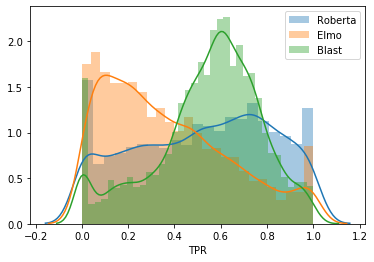

In [31]:
sns.distplot(attn_df['TPR'].dropna(), label='Roberta')
sns.distplot(elmo_df['TPR'].dropna(), label='Elmo')
sns.distplot(blast_df['TPR'].dropna(), label='Blast')

plt.legend()

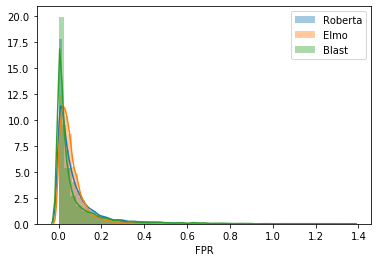

In [32]:
sns.distplot(attn_df['FPR'].dropna(), label='Roberta')
sns.distplot(elmo_df['FPR'].dropna(), label='Elmo')
sns.distplot(blast_df['FPR'].dropna(), label='Blast')

plt.legend()

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

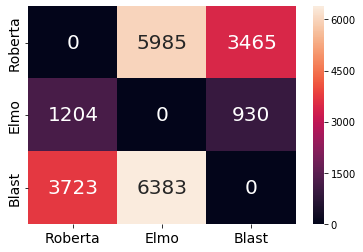

In [33]:
comp_df = pd.DataFrame([
    [0, np.sum(attn_df['TPR'] > elmo_df['TPR']), np.sum(attn_df['TPR'] > blast_df['TPR'])],
    [np.sum(elmo_df['TPR'] > attn_df['TPR']), 0, np.sum(elmo_df['TPR'] > blast_df['TPR'])],
    [np.sum(blast_df['TPR'] > attn_df['TPR']), np.sum(blast_df['TPR'] > elmo_df['TPR']), 0]], 
    columns=['Roberta', 'Elmo', 'Blast'], index=['Roberta', 'Elmo', 'Blast'])
sns.heatmap(comp_df, annot=True, fmt='g', annot_kws={"size": 20})
plt.yticks(fontsize=14, va="center")
plt.xticks(fontsize=14)


(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

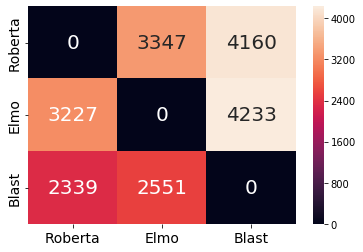

In [34]:
col = 'FPR'
comp_df = pd.DataFrame([
    [0, np.sum(attn_df[col] > elmo_df[col]), np.sum(attn_df[col] > blast_df[col])],
    [np.sum(elmo_df[col] > attn_df[col]), 0, np.sum(elmo_df[col] > blast_df[col])],
    [np.sum(blast_df[col] > attn_df[col]), np.sum(blast_df[col] > elmo_df[col]), 0]], 
    columns=['Roberta', 'Elmo', 'Blast'], index=['Roberta', 'Elmo', 'Blast'])
sns.heatmap(comp_df, annot=True, fmt='g', annot_kws={"size": 20})
plt.yticks(fontsize=14, va="center")
plt.xticks(fontsize=14)

(array([0.5, 1.5, 2.5]), <a list of 3 Text xticklabel objects>)

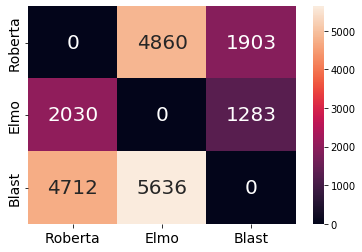

In [35]:
col = 'PPV'
comp_df = pd.DataFrame([
    [0, np.sum(attn_df[col] > elmo_df[col]), np.sum(attn_df[col] > blast_df[col])],
    [np.sum(elmo_df[col] > attn_df[col]), 0, np.sum(elmo_df[col] > blast_df[col])],
    [np.sum(blast_df[col] > attn_df[col]), np.sum(blast_df[col] > elmo_df[col]), 0]], 
    columns=['Roberta', 'Elmo', 'Blast'], index=['Roberta', 'Elmo', 'Blast'])
sns.heatmap(comp_df, annot=True, fmt='g', annot_kws={"size": 20})
plt.yticks(fontsize=14, va="center")
plt.xticks(fontsize=14)

In [38]:
elmo_df = elmo_df.loc[attn_df.index]
attn_df = attn_df.loc[elmo_df.index]

In [39]:
tpr_diff = (attn_df[2] - elmo_df[2]).dropna()
fpr_diff = (attn_df[3] - elmo_df[3]).dropna()

In [40]:
np.sum(tpr_diff > 0), np.sum(tpr_diff < 0)

(5985, 1204)

In [41]:
np.sum(fpr_diff > 0), np.sum(fpr_diff < 0)

(3347, 3227)

In [42]:
tpr_diff.loc[tpr_diff<0].sort_values()

0       1     
Q0TAP6  Q7VVU3   -363
Q605M0  Q2KYF3   -353
A4J5C3  Q9SRV5   -301
Q62LZ2  C1KVY0   -285
Q1I4X3  A6TYK8   -247
                 ... 
A3FPN7  B4QIG6     -1
A4YRT2  B1HX43     -1
B8ZQ69  B8D6B2     -1
Q34724  Q7HFG0     -1
P52426  Q126N9     -1
Name: 2, Length: 1204, dtype: int64